# Test treatment effects under placebo

The set up for the following tests is to test the regression estimator for the treatment effect in the case that the treatment effect is 0, but the treatment is related to the risk factor affecting the outcome.


## Example A.

Consider a scenario of strong confounding with one binary risk factor $X$, one binary ``placebo'' treatment $T$, and one binary outcome $Y$.  These occur according to the following probabilities
\begin{align*}
P(X=1) &= 0.25 \\
P(T=1 \mid X=1) &= 0.95 \\
P(T=1 \mid X=0) &= 0.05 \\
P(Y=1 \mid X=1) &= 0.95 \\
P(Y=1 \mid X=0) &= 0.05 \,.
\end{align*}

The outcome does not depend on the treatment, that is, the true treatment effect is 0.  
However, confounding will lead to erroneously high treatment effect estimates for the regression estimator, but matching prior to estimating the treatment effect mitigates this bias.

Specifically, we generate $N=200$ units $\{(X_i, T_i, Y_i)\}_{i=1}^N$.

In [1]:
N = 200
p_has_risk_factor = 0.25
p_treat_given_risk_factor = 0.95
p_treat_given_no_risk_factor = 0.05
p_outcome_given_risk_factor = 0.95
p_outcome_given_no_risk_factor = 0.05
n_iter = 1000

### Example A. The regression estimator.

We fit $\mathbb{E} \{Y \,|\, X=x, T=t\} = g(x,t) = \mathrm{logistic}(\beta_0 + \beta x + \gamma_0 t)$ using logistic regression. We estimate the treatment effect as $\frac{1}{N} \sum_{i=1}^N g(X_i,1) - g(X_i,0)$.
After 1000 runs, the $95\%$ bootstrap confidence interval for the treatment effect is calculated.

In [2]:
from treatment_effect_under_placebo_simulations import scenario_A, treatment_effect_estimator
method = 'regression'   
cis, _ = scenario_A(N,
                    n_iter,
                    p_has_risk_factor,
                    p_treat_given_risk_factor,
                    p_treat_given_no_risk_factor,
                    p_outcome_given_risk_factor,
                    p_outcome_given_no_risk_factor,
                    method)
print('Treatment Effect CI: ({:.2f},  {:.2f})'.format(cis[0],cis[1]))

Treatment Effect CI: (0.10,  0.28)


This scenario works as follows. 

In [3]:
# First, generate the risk factor, treatment, outcome variables.
import numpy as np
x = np.random.binomial(1,p_has_risk_factor,size=(N,))
treat = np.random.binomial(1,p_treat_given_risk_factor*x+p_treat_given_no_risk_factor*(1-x))         
y = np.random.binomial(1,p_outcome_given_risk_factor*x+p_outcome_given_no_risk_factor*(1-x))

# Summarize
X = np.vstack([x, treat]).T
import pandas as pd
df = pd.DataFrame(X, columns=['risk factor', 'treatment'])
print(df.groupby(['risk factor', 'treatment']).size())

# Second, predict the outcome using logistic regression.
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2')  
clf.fit(X,y)

# We use the G-computation estimator for the treatment effect
estimated_treatment_effect = treatment_effect_estimator(X,clf,method='gcomp')
print('Estimated treatment effect = {:.2f}'.format(estimated_treatment_effect))

risk factor  treatment
0            0            140
             1              4
1            0              4
             1             52
dtype: int64
Estimated treatment effect = 0.15


### Example A. Exact matching, followed by applying the G-computation estimator

In [4]:
# Sample matches between treatment and control groups.
from treatment_effect_under_placebo_simulations import match_exact
idx = match_exact(x, treat)
X = np.vstack([x, treat]).T[idx,:]  
y_ = y[idx]

# Summarize
df = pd.DataFrame(X, columns=['risk factor', 'treatment'])
print(df.groupby(['risk factor', 'treatment']).size())

# Then predict the outcome using logistic regression.
clf.fit(X,y_)

# Use G-computation estimator for the treatment effect.
estimated_treatment_effect = treatment_effect_estimator(X,clf,method='gcomp')
print('Estimated treatment effect = {:.2f}'.format(estimated_treatment_effect))

risk factor  treatment
0            0            4
             1            4
1            0            4
             1            4
dtype: int64
Estimated treatment effect = -0.07


### Example A. Distance matching, followed by applying the G-computation estimator

In [5]:
# Sample matches between treatment and control groups.
from treatment_effect_under_placebo_simulations import match_dist
idx = match_dist(x, treat, caliper=0.9) 
X = np.vstack([x, treat]).T[idx,:]  
y_ = y[idx]

# Summarize
df = pd.DataFrame(X, columns=['risk factor', 'treatment'])
print(df.groupby(['risk factor', 'treatment']).size())

# Then predict the outcome using logistic regression.
clf.fit(X,y_)

# Estimate treatment effect.
estimated_treatment_effect = treatment_effect_estimator(X,clf,method='gcomp')
print('Estimated treatment effect = {:.2f}'.format(estimated_treatment_effect))

risk factor  treatment
0            0             4
             1             4
1            0            52
             1            52
dtype: int64
Estimated treatment effect = -0.05


In [6]:
# idx

### Example A. Run all estimators for treatment effect CIs.

In [7]:
# Parameter Settings
N = 200
p_has_risk_factor = 0.25
p_treat_given_risk_factor = 0.95
p_treat_given_no_risk_factor = 0.05
p_outcome_given_risk_factor = 0.95
p_outcome_given_no_risk_factor = 0.05
n_iter = 1000

# Run all methods
methods = ['regression', 'matchexact', 'matchdist, greedy', 'matchdist, 1-1']
for method in methods:
    cis, num_valid = scenario_A(N,
                                n_iter,
                                p_has_risk_factor,
                                p_treat_given_risk_factor,
                                p_treat_given_no_risk_factor,
                                p_outcome_given_risk_factor,
                                p_outcome_given_no_risk_factor,
                                method)
    print('Method {}, Treatment Effect CI: ({:.4f},  {:.4f}); {} valid runs.'.format(method,cis[0],cis[1],num_valid))

Method regression, Treatment Effect CI: (0.0920,  0.2922); 1000 valid runs.
Method matchexact, Treatment Effect CI: (-0.1355,  0.0492); 955 valid runs.
Method matchdist, greedy, Treatment Effect CI: (-0.1162,  0.6415); 946 valid runs.
Method matchdist, 1-1, Treatment Effect CI: (-0.1363,  0.0512); 970 valid runs.


##### Ok. So admitting the $95\%$ risk is a little extreme, let's look at the CIs for different risks.

In [8]:
# Parameter Settings
N = 200
p_has_risk_factor = 0.25
n_iter = 1000

probs = np.linspace(0.55, 0.95, 9)[::-1]     # = p_treat_given_risk_factor = p_outcome_given_risk_factor

cis_ = {}

# Run all methods
methods = ['regression', 'matchexact', 'matchdist, greedy', 'matchdist, 1-1']
for method in methods:
    cis = np.zeros((len(probs),2))
    for i, p in enumerate(probs):
        p_treat_given_risk_factor = p
        p_treat_given_no_risk_factor = 1. - p_treat_given_risk_factor
        p_outcome_given_risk_factor = p
        p_outcome_given_no_risk_factor = 1. - p_outcome_given_risk_factor           
        cis[i,:], num_valid = scenario_A(N,
                                    n_iter,
                                    p_has_risk_factor,
                                    p_treat_given_risk_factor,
                                    p_treat_given_no_risk_factor,
                                    p_outcome_given_risk_factor,
                                    p_outcome_given_no_risk_factor,
                                    method)
        print('Method {}, Treatment Effect CI: ({:.4f},  {:.4f}); {} valid runs.'.format(method,cis[i,0],cis[i,1],num_valid))
    cis_[method] = cis

Method regression, Treatment Effect CI: (0.0911,  0.2856); 1000 valid runs.
Method regression, Treatment Effect CI: (0.0060,  0.2118); 1000 valid runs.
Method regression, Treatment Effect CI: (-0.0479,  0.1590); 1000 valid runs.
Method regression, Treatment Effect CI: (-0.0757,  0.1567); 1000 valid runs.
Method regression, Treatment Effect CI: (-0.0997,  0.1382); 1000 valid runs.
Method regression, Treatment Effect CI: (-0.1160,  0.1332); 1000 valid runs.
Method regression, Treatment Effect CI: (-0.1217,  0.1369); 1000 valid runs.
Method regression, Treatment Effect CI: (-0.1169,  0.1249); 1000 valid runs.
Method regression, Treatment Effect CI: (-0.1278,  0.1227); 1000 valid runs.
Method matchexact, Treatment Effect CI: (-0.1327,  0.0434); 955 valid runs.
Method matchexact, Treatment Effect CI: (-0.1483,  0.0838); 999 valid runs.
Method matchexact, Treatment Effect CI: (-0.1544,  0.1004); 1000 valid runs.
Method matchexact, Treatment Effect CI: (-0.1460,  0.1196); 1000 valid runs.
Met

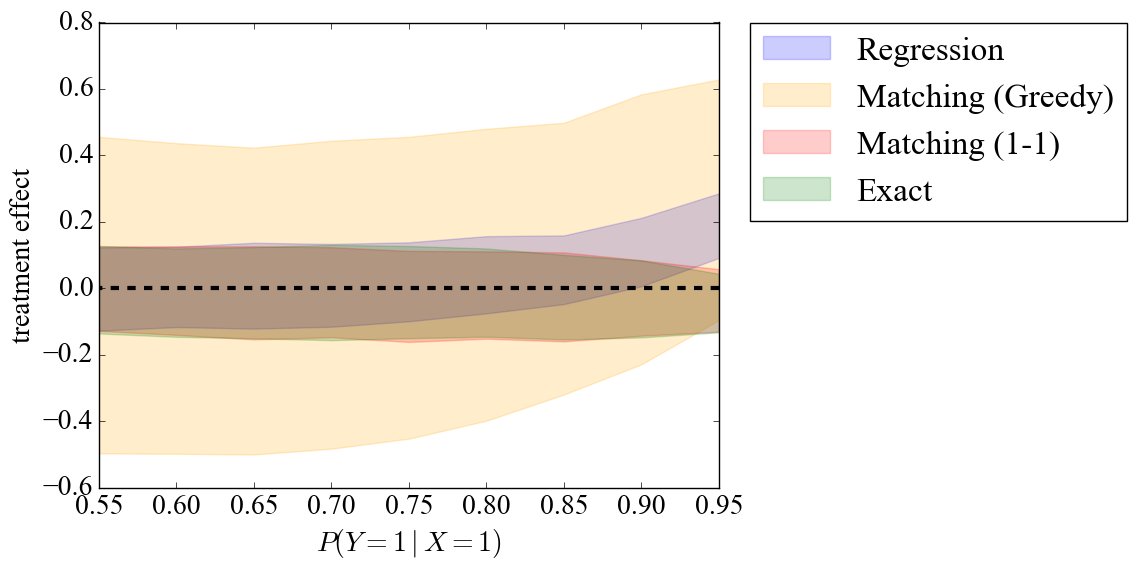

In [14]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'family':'Times New Roman', 'weight':'normal', 'size':20})
import matplotlib.pyplot as plt

# Plot the CIs
fig = plt.figure()    
fig.set_size_inches(8,6)  
ax = fig.add_subplot(111) 
# methods = ['regression', 'matchexact', 'matchdist, greedy', 'matchdist, 1-1']
plt.fill_between(probs,cis_['regression'][:,0],cis_['regression'][:,1],alpha=0.2,color='blue',label='Regression')
plt.fill_between(probs,cis_['matchdist, greedy'][:,0],cis_['matchdist, greedy'][:,1],alpha=0.2,color='orange',label='Matching (Greedy)')
plt.fill_between(probs,cis_['matchdist, 1-1'][:,0],cis_['matchdist, 1-1'][:,1],alpha=0.2,color='red',label='Matching (1-1)')
plt.fill_between(probs,cis_['matchexact'][:,0],cis_['matchexact'][:,1],alpha=0.2,color='green',label='Exact')
plt.plot(probs,np.zeros(len(probs)),'--',color='black',linewidth=3.)
plt.xlabel('$P(Y=1 \mid X=1)$')
plt.ylabel('treatment effect')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0., numpoints=3)
plt.show()